In [256]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

In [348]:
flatten = lambda l: [item for sublist in l for item in sublist]

def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def tile(im, rows=14, columns=6):
    M = im.shape[0] // rows
    N = im.shape[1] // columns
    rows = []
    for y in range(0, im.shape[1],N):
        row = []
        for x in range(0, im.shape[0],M):
            row.append(im[x:x+M,y:y+N])
        rows.append(row)
    #print(f"rows: {len(tiles)}")
    #print(f"columns: {len(tiles[0])}")
    return rows

def shuffle_time_in_chunks(df, n):
    """Break df into n-lengths mini dfs"""
    assert len(df) > n*10, "doesn't meet minimum number of chunks"
    assert (len(df) % n) == 0, "all chunks equal size"

    chunk_count = len(df[0]) // n
    chunks = []
    for x in range(0, len(df), n):
        chunks.append(df[x:x + n])
    random.shuffle(chunks)
    return pd.concat(chunks, axis=0)
    

In [349]:
imagebak.shape

(480, 640, 3)

In [350]:
import cv2
vidcap = cv2.VideoCapture('./data/train.mp4')

success = True

xs = []
while True:
    success, image = vidcap.read()
    if not success:
        break
    else:
        imagebak = image
    tiles = tile(image)
    xs.append([variance_of_laplacian(i) for i in flatten(tiles)])
    if len(xs) % 1000 == 0:
        print('.', end='')

....................

In [351]:
print(f"rows: {len(tiles)}")
print(f"columns: {len(tiles[0])}")

rows: 7
columns: 15


In [352]:
y = pd.read_csv('./data/train.txt', header=None)
X = pd.DataFrame(xs)
print(len(X))
Xy = X.copy(deep=True)
Xy['y'] = y
chunksize = 200
Xy = shuffle_time_in_chunks(Xy, chunksize)
print(len(Xy))
X = Xy[X.columns]
y = Xy[['y']]

20400
20400


In [363]:
testcount = chunksize * 25

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=testcount, shuffle=False)
print(testcount/len(Xy))

0.24509803921568626


In [364]:
m = DummyRegressor(strategy='mean')
svr = SVR(C=.3)

In [365]:
m.fit(Xtrain, ytrain['y'])
svr.fit(Xtrain, ytrain['y'])

SVR(C=0.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [366]:
ytest_pred = svr.predict(Xtest)
ytrain_pred = svr.predict(Xtrain)
print(mean_squared_error(ytest, m.predict(Xtest)))
print(mean_squared_error(ytest, ytest_pred))
print(mean_squared_error(ytrain, ytrain_pred))

50.82410743502666
46.18240498469606
18.029450497810053


testing error, training error
- naive shuffle, mean dummy regressor = 68
- naive shuffle, 1x1x(varlaplace) tilessvr.predict(Xtest), SVR(C=?) = 44
- naive shuffle, 6x3x(varlaplace) tiles, SVR(C=30) = 19.4
- naive shuffle, 12x5x(varlaplace) tiles, SVR(C=30) = 10.3
- naive shuffle, test_size=.150, 26x12x(varlaplace) tiles, SVR(C=.2) = 17.9, 18.1
-    no shuffle, test_size=.150, 26x12x(varlaplace) tiles, SVR(C=.2) = 33.2, 17.7
- chunk shuffle, test_size=.147, 26x12x(varlaplace) tiles, SVR(C=.2) = 39, 16.6
- chunk shuffle, test_size=.147, 26x12x(varlaplace) tiles, SVR(C=.1) = 42, 20
- chunk shuffle, test_size=.147, 26x12x(varlaplace) tiles, SVR(C=.5) = 36, 12
- chunk shuffle, test_size=.147, 14x06x(varlaplace) tiles, SVR(C=.5) = 27, 19
- chunk shuffle, test_size=.147, 14x06x(varlaplace) tiles, SVR(C=.3) = 28.5, 21.5, 39.5
- chunk shuffle, test_size=.245, 14x06x(varlaplace) tiles, SVR(C=.3) = 28.5, 21.5, 39.5

## ideas
x start chunking
- increase test_size to at least .25
- accelleration limits based on testing set. This could be a post processing step.concat

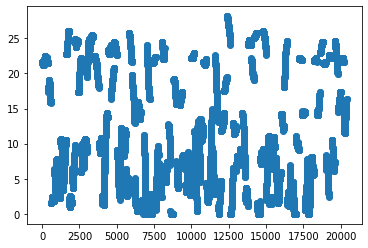

In [347]:
plt.plot(y.values, marker='o', linewidth=0);

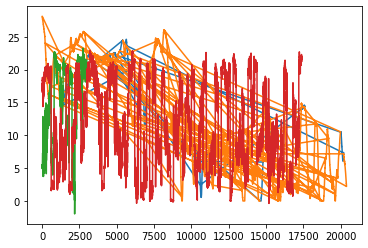

In [343]:
plt.plot(ytest)
plt.plot(ytrain)
plt.plot(ytest_pred)
plt.plot(ytrain_pred)